# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** first_name_1 last_name_1, first_name_2 last_name_2, first_name_3 last_name_3  
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

In [17]:
import importlib
import matplotlib.pyplot as plt
import numpy as np

import lab02_functions as imPro
import skimage
import skimage.transform
from numpy.fft import fft

importlib.reload(imPro)

<module 'lab02_functions' from '/home/arthur/dev/python/ImageAnalysisLabs/lab02/lab02_functions.py'>

# Part 1
Dataset source: MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Our goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.

(for arthur, here is what to do)
Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

## 1.1 Data visualization

In [18]:
zeros=imPro.get_zeros()
ones = imPro.get_ones()

## 1.2 Fourier descriptors

### The theory

Fourier Descriptors (FD) is a method that can be used to encode contours and that offers a comparison tool between different contours. 
The main idea is to get the most Fourier Series of the complex path, and then to extract the main harmonics. 
By only keeping the most important harmonics, it is possible to reconstruct a contour with almost all the variance of the initial contour.

Assume you have a contour $x_i, y_i$ for $i = 1,...,N$ different points. Construct the complex path $u_k = x_k + j \cdot y_k$. 
Let's denote by $f_j$ the j-iest element of the Fourier Serie, then the FD are all the $f_j$ fourier's harmonic. 

### Example of FD reconstruction 

<Figure size 432x288 with 0 Axes>

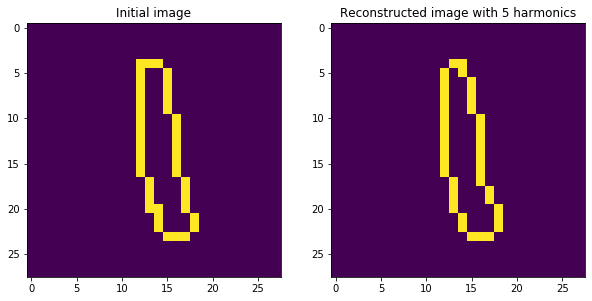

In [19]:
img = ones[1]
[X,Y] = imPro.get_outmost_contour(img)
im_contour = imPro.get_contour_image([X,Y])

signal = X + 1j * Y
fourier = np.fft.fft(signal)

amplitudes = np.abs(fourier)
phases = np.angle(fourier)

k = 5 # number of harmonic to use
fourier[k:-k] = 0
fourier_inv = np.fft.ifft(fourier)

X_hat = np.rint(fourier_inv.real).astype(int)
Y_hat = np.rint(fourier_inv.imag).astype(int)
im_contour_hat = imPro.get_contour_image([X_hat, Y_hat])

plt.figure()
fig, axs = plt.subplots(1,2,figsize = (10,5))
axs[0].imshow(im_contour)
axs[0].set_title('Initial image')
axs[1].imshow(im_contour_hat)
axs[1].set_title('Reconstructed image with {} harmonics'.format(k))
plt.show()

We can see that the reconstruction is very good. This illustration shows us how to use the Fourier Descriptor for reconstruction, but eventually this is not what we want to do. We want to be able to classify using the Fourier Descriptors of one path. 

## Classificaiton with Fourier Descriptors

### First case: normal descriptors

The first thing that one can try is to perform classification using the value of the N-first amplitudes of the fourier descriptors for each contour and then plot it. The code above shows how we can perform classification using a very simple feature vector $x_{feature}$, containing the amplitudes of the first and second, or first and thir, higest amplitudes of all FDs. 

<Figure size 432x288 with 0 Axes>

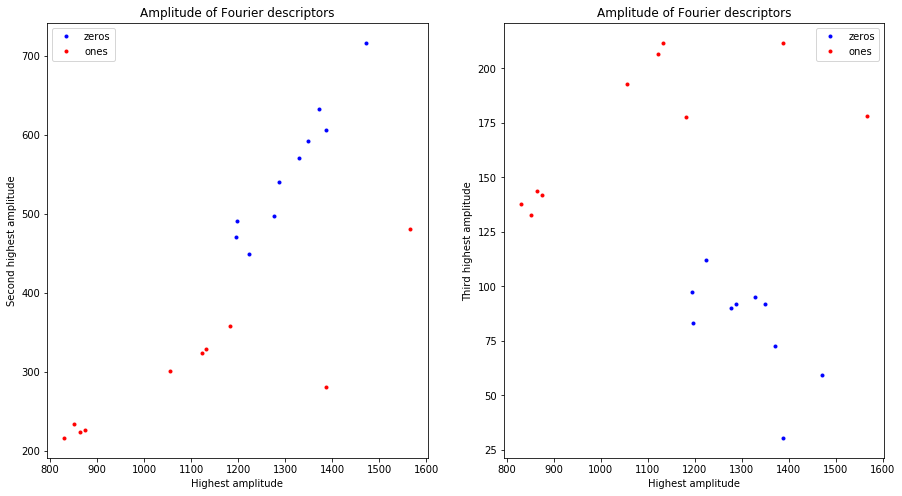

In [20]:
amplitudes_zeros = []
amplitudes_ones = []

for img in zeros:
    contour = imPro.get_outmost_contour(img)
    amplitudes = imPro.get_amplitude_first_descriptors(contour, n_descriptor = 4)
    amplitudes_zeros.append(amplitudes)

for img in ones:
    contour = imPro.get_outmost_contour(img)
    amplitudes = imPro.get_amplitude_first_descriptors(contour, n_descriptor = 4)
    amplitudes_ones.append(amplitudes)

amplitudes_zeros = np.array(amplitudes_zeros)
amplitudes_ones = np.array(amplitudes_ones)

plt.figure()
fig, axs = plt.subplots(1,2, figsize = (15,8))

axs[0].plot(amplitudes_zeros[:,0], amplitudes_zeros[:,1],'.b', label = 'zeros')
axs[0].plot(amplitudes_ones[:,0], amplitudes_ones[:,1],'.r', label = 'ones')
axs[0].set_xlabel('Highest amplitude')
axs[0].set_ylabel('Second highest amplitude')
axs[0].set_title('Amplitude of Fourier descriptors')
axs[0].legend()

axs[1].plot(amplitudes_zeros[:,0], amplitudes_zeros[:,2],'.b', label = 'zeros')
axs[1].plot(amplitudes_ones[:,0], amplitudes_ones[:,2],'.r', label = 'ones')
axs[1].set_xlabel('Highest amplitude')
axs[1].set_ylabel('Third highest amplitude')
axs[1].set_title('Amplitude of Fourier descriptors')
axs[1].legend()

plt.show()

We see using this method that the contours are **quite separable**. Let's see if we can obtain a better separation using a technique named 'normalisation'. 

## Fourier Normalisation

There are four transformations that can influence Fourier Transforms: rotation, scaling, translation and selection of the starting point. What we want to do is to make a robust method that doesn't depend on any of those transformations. Each different case needs to be traited separatly. 

### Recap of transformation and how to normalize each one of them

1. **Scalling**: After scalling, $f_l$ becomes $f_l'=s\cdot f_l$. 

2. **Translation**: After a translation by an offset $z_0$, $f_l$ becomes $f_l'=f_l + z_0 \cdot \delta(l)$, i.e. it affects only the DC component of the FDs. 

3. **Selection of starting points**: After selecting $k_0$ as initial point, $f_l$ becomes $f_l'=f_l \cdot e^{-j\cdot\frac{2\pi k_0}{N}l}$. 

4. **Rotation**: After a rotation of $\theta$, $f_l$ becomes $f_l'=f_l \cdot e^{j\theta}$ which is an offset of all the phases by a constant value. 

The following block illustrates the effect of rotation and of scalling, just as a 'proof' of concept.

Text(0.5, 0.98, 'Effect of scalling over the phase of the Fourier Descriptors')

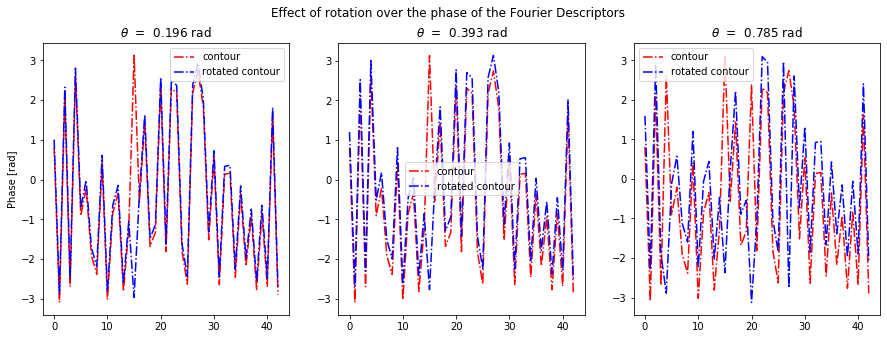

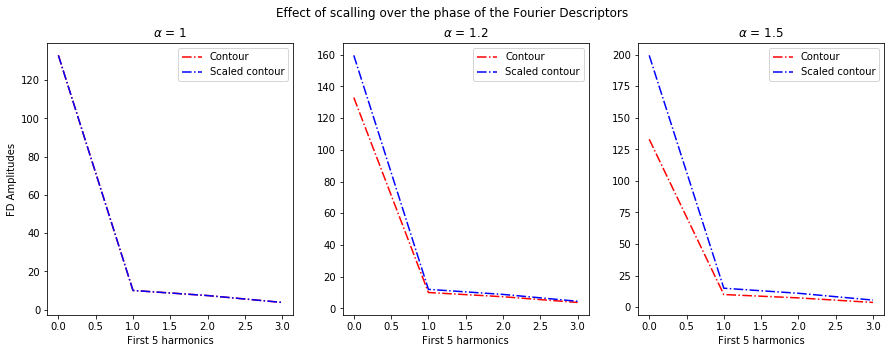

In [21]:
# %% Rotation effect (the modulus is constant)
fig, axs = plt.subplots(1,3,figsize = (15,5))
img = ones[1]
imPro.plot_FD_rotation_invariance(img, np.pi/16, axs[0])
imPro.plot_FD_rotation_invariance(img, np.pi/8, axs[1])
imPro.plot_FD_rotation_invariance(img, np.pi/4, axs[2])
axs[0].set_ylabel('Phase [rad]')
fig.suptitle("Effect of rotation over the phase of the Fourier Descriptors")

# %% Scalling effect (the phase is constant)
fig, axs = plt.subplots(1,3,figsize = (15,5))
img = ones[1]
imPro.plot_FD_scaling_invariance(img, 1, axs[0])
imPro.plot_FD_scaling_invariance(img, 1.2, axs[1])
imPro.plot_FD_scaling_invariance(img, 1.5, axs[2])
axs[0].set_ylabel('FD Amplitudes')
fig.suptitle("Effect of scalling over the phase of the Fourier Descriptors")

### About the feature vector

To have a good classification, we must use a good feature vector $x_{features}$, that embededs good properties. Dealing with invariances, it is important to make a proper selection of feature vector. On the previ

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

In [22]:
#  Load zeros
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load ones
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

NameError: name 'os' is not defined

### 2.2 Additional method(s) and conclusion
Add your implementations and discussions here

In [ ]:
imPro